In [8]:
# Function Hess_Comp evaluates the hessian that is necessary to estimate the step-size at each of the updates.
def Hess_Comp(y,x_list):
    grads=[];H=[];grads1=[];H1=[];
    grads.append(tf.gradients(y, x_list))
    for i in range(0,len(grads[0])):
        if grads[0][i] == None:
            grads1.append(cons(0))   
        else: 
            grads1.append(grads[0][i])
    H.append([tf.gradients(y_, x_list) for y_ in grads1])
    for i in range(0,len(H[0])):
        for j in range(0,len(H[0][i])):
            if H[0][i][j] == None:
                H1.append(cons(0))   
            else: 
                H1.append(H[0][i][j])
    grads1 = tf.reshape(grads1,[len(x_list),1])        
    H1 = tf.reshape(H1,[len(x_list),len(x_list)])
    return(H1,grads1)

In [10]:
# Function Jaco_Comp evaluates the Jacobian that is necessary to approximate Hessian.
def Jaco_comp(y,x_list):
    Jaco=[];Jaco1=[];
    Jaco.append([tf.gradients(y_, x_list) for y_ in y])
    for i in range(0,len(Jaco[0])):
        for j in range(0,len(Jaco[0][i])):
            if Jaco[0][i][j] == None:
                Jaco1.append(cons(0))   
            else: 
                Jaco1.append(Jaco[0][i][j])
    Jaco1 = tf.reshape(Jaco1,[len(y),len(x_list)])
    return(Jaco1)

In [9]:
# This function is called in 'Hess_Comp' function to initisalise those elements in the Hessian matrix where the 
# double differential is zero.
def cons(x):
    return tf.constant(x, dtype=tf.float32)

In [11]:
import tensorflow as tf
import numpy as np
import random

#Logistic Regression
#data_x=np.random.rand(10)
data_x = [-1,0,4,7,10]
data_y= [0,0,1,1,1]

#random.shuffle(create_y)
batch_size = len(data_x)

# Input and Output. No batch_size for simplicity.
x = tf.placeholder(shape=[batch_size], dtype=tf.float32, name="x")
y = tf.placeholder(shape=[batch_size], dtype=tf.float32, name="y")

# Weight and bias.
W = tf.Variable(tf.ones(shape=[1]), dtype=tf.float32, name="W")
b = tf.Variable(tf.zeros(shape=[1]), dtype=tf.float32, name="b")
c = tf.constant

# Making a prediction and comparing it to the true output
pred = tf.sigmoid(x * W + b)
prediction = tf.unstack(pred)
predictions = [tf.cast(tf.greater(x,cons(0)),tf.int32) for x in prediction]

loss = 0.5 * (y - pred)**2/batch_size
loss = tf.unstack(loss)
wrt_variables = [W, b]

# Hess_Comp evaluates the gradient of the loss with respect to the newest variables.
[Hess23,grad]=Hess_Comp(loss,wrt_variables)

# Jaco_Comp evaluates the Jacobian of the loss with respect to the newest variables.
Jacob = Jaco_comp(loss,wrt_variables)

# Approximate Hessian as J'J
Hess=tf.matmul(tf.transpose(Jacob),tf.stack(Jacob)); 

# Inverting the matrix
Inv_Hess=tf.matrix_inverse(Hess)

# Get the step size ((J'J)^-1)g
update_directions = -tf.matmul(Inv_Hess,grad)
update_directions=(tf.unstack(update_directions))

#Add the step size to the varibles to update them
op_apply_updates = [
    v.assign_add(up)
    for v, up in zip(wrt_variables, update_directions)
]



In [12]:
# Initialize variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())


# First loss
comp_loss = sess.run(
    loss,
    feed_dict={
        x: data_x,
        y: data_y
    }
)
print("Initial loss:", comp_loss)
loss_iter=np.zeros(21);
loss_iter[0]=sum(comp_loss)/len(data_x);

# Weight and bias update, "training" phase:
for iteration in range(20):
    
    _,g1,h = sess.run(
        [op_apply_updates,wrt_variables,Hess],
        feed_dict={
            x: data_x,
            y: data_y
        }
    )
    comp_loss = sess.run(
        loss,
        feed_dict={
            x: data_x,
            y: data_y
        }
    )
    print("Loss after iteration {}: {}".format(iteration+1, sum(comp_loss)/len(data_x)))
    if(sum(comp_loss)/len(data_x)<0.05):
        loss_iter[iteration+1:]=sum(comp_loss)/len(data_x);
        break
    loss_iter[iteration+1]=sum(comp_loss)/len(data_x);
Predicted = sess.run(pred, feed_dict={x: data_x})
    
# Results:
print("Prediction:", Predicted)
print("Expected:", data_y)



Initial loss: [0.0072329491, 0.025, 3.2350476e-05, 8.2991626e-08, 2.0628618e-10]
Loss after iteration 1: 9.896923445165515e-37
Prediction: [  0.00000000e+00   7.03453004e-18   1.00000000e+00   1.00000000e+00
   1.00000000e+00]
Expected: [0, 0, 1, 1, 1]


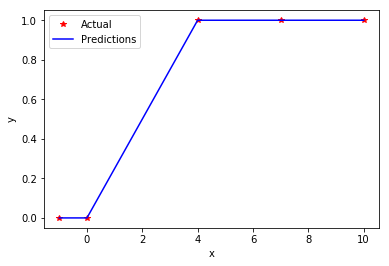

In [15]:
import matplotlib.pyplot as plt
Actual, = plt.plot(data_x,data_y,'r*')
Predictions, = plt.plot(data_x,Predicted,'b')
plt.legend([Actual, Predictions], ['Actual', 'Predictions'])
plt.ylabel('y')
plt.xlabel('x')
plt.show()


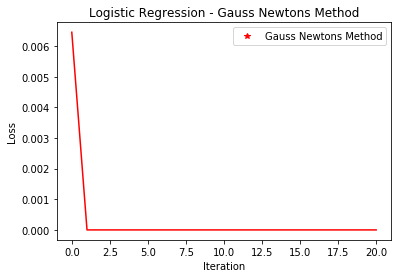

In [17]:
Loss, = plt.plot(loss_iter,'r-')
plt.legend([Actual, Predictions], ['Gauss Newtons Method'])
plt.ylabel('Loss')
plt.title('Logistic Regression - Gauss Newtons Method')
plt.xlabel('Iteration')
plt.show()